In [1]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [2]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [3]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [4]:
from astropy.io import fits

In [5]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [6]:
from astroquery.svo_fps import SvoFps

In [7]:
import numpy as np

In [8]:
import reproject

In [9]:
from astropy import units as u

In [10]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [16]:
fh_466 = fits.open(f'{basepath}/F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits')
fh_410 = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits')

In [17]:
ww466 = wcs.WCS(fh_466['SCI'].header)
ww410 = wcs.WCS(fh_410['SCI'].header)

Set DATE-AVG to '2022-08-28T02:01:42.785' from MJD-AVG.
Set DATE-END to '2022-08-28T02:29:48.969' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.664510 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526442456.371 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-08-28T03:05:31.909' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.633936 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526083300.815 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [18]:
instrument = fh_466[0].header['INSTRUME']
telescope = fh_466[0].header['TELESCOP']
filt466 = fh_466[0].header['PUPIL']
wavelength_table_466 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt466}')
filt410 = fh_410[0].header['FILTER']
wavelength_table_410 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt410}')

In [28]:
filterlist = SvoFps.get_filter_list('JWST', 'NIRCam')
filterlist.add_index('filterID')

In [31]:
filterlist.loc['JWST/NIRCam.F466N']['WidthEff']

535.40523943323

In [32]:
filterlist.loc['JWST/NIRCam.F410M']['WidthEff']

4262.8579023938

In [33]:
fractional_bandwidth_466 = filterlist.loc['JWST/NIRCam.F466N']['WidthEff'] / filterlist.loc['JWST/NIRCam.F410M']['WidthEff']

In [36]:
data_466_proj_410,_ = reproject.reproject_exact(fh_466['SCI'], fh_410['SCI'].header)

Set DATE-AVG to '2022-08-28T02:01:42.785' from MJD-AVG.
Set DATE-END to '2022-08-28T02:29:48.969' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.664510 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526442456.371 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-08-28T03:05:31.909' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.633936 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526083300.815 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [38]:
cont410_sub_bra = fits.getdata(f'{basepath}/images/F410_minus_F405_nrca.fits')

In [40]:
f466_minus_cont = data_466_proj_410 - cont410_sub_bra #* fractional_bandwidth_466
fits.PrimaryHDU(data=f466_minus_cont, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F466_minus_F410cont_nrca.fits', overwrite=True)

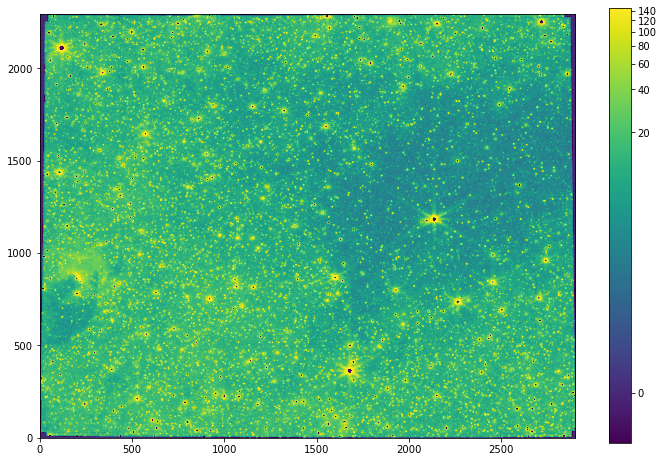

In [41]:
pl.figure(figsize=(12,8))
pl.imshow(cont410_sub_bra, norm=simple_norm(cont410_sub_bra, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

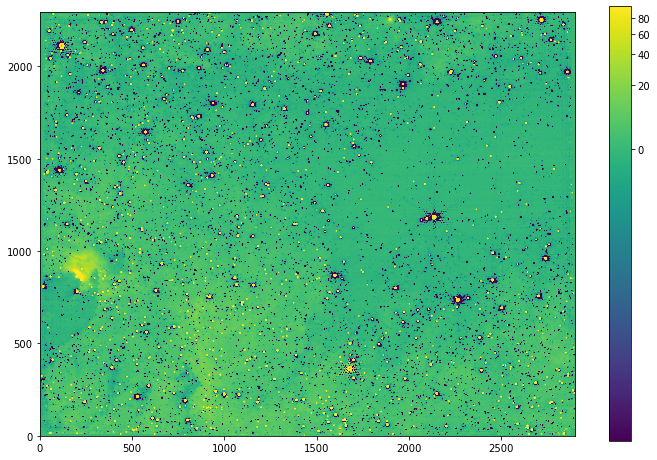

In [42]:
pl.figure(figsize=(12,8))
pl.imshow(f466_minus_cont, norm=simple_norm(f466_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

In [43]:
stars_f466 = DAOStarFinder(threshold=60, fwhm=2.302, peakmax=1e4)(fh_466['SCI'].data)
stars_f466['skycoord'] = ww466.pixel_to_world(stars_f466['xcentroid'], stars_f466['ycentroid'])
len(stars_f466)

7834

In [44]:
stars_410 = DAOStarFinder(threshold=10, fwhm=2.302, peakmax=900)(fh_410['SCI'].data)
stars_410['skycoord'] = ww410.pixel_to_world(stars_410['xcentroid'], stars_410['ycentroid'])
len(stars_410)

48603

In [45]:
matches, sep, _ = stars_f466['skycoord'].match_to_catalog_sky(stars_410['skycoord'], nthneighbor=1)

for cn in stars_f466.colnames:
    stars_f466.rename_column(cn, f"{cn}_466")
for cn in stars_410.colnames:
    stars_410.rename_column(cn, f"{cn}_410")
                         
stars_f466.add_column(name="sep_410_466", col=sep)
stars_f466.add_column(name="id_410_466", col=matches)
mergetbl = table.hstack([stars_f466, stars_410[matches]], join_type='exact')

(array([6.866e+03, 6.820e+02, 2.300e+02, 4.100e+01, 1.200e+01, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([3.40222011e-04, 2.06739688e-01, 4.13139153e-01, 6.19538619e-01,
        8.25938085e-01, 1.03233755e+00, 1.23873702e+00, 1.44513648e+00,
        1.65153595e+00, 1.85793541e+00, 2.06433488e+00]),
 <BarContainer object of 10 artists>)

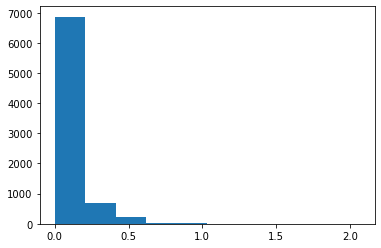

In [46]:
pl.hist(mergetbl['sep_410_466'].to(u.arcsec).value)

(-0.5, 0.5, -0.5, 0.5)

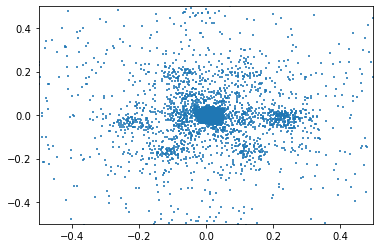

In [47]:
radiff = (mergetbl['skycoord_466'].ra - mergetbl['skycoord_410'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_466'].dec - mergetbl['skycoord_410'].dec).to(u.arcsec)
pl.scatter(radiff, decdiff, marker=',', s=1, alpha=0.8)
pl.axis([-0.5,0.5,-0.5,0.5])

(-0.05, 0.05, -0.05, 0.05)

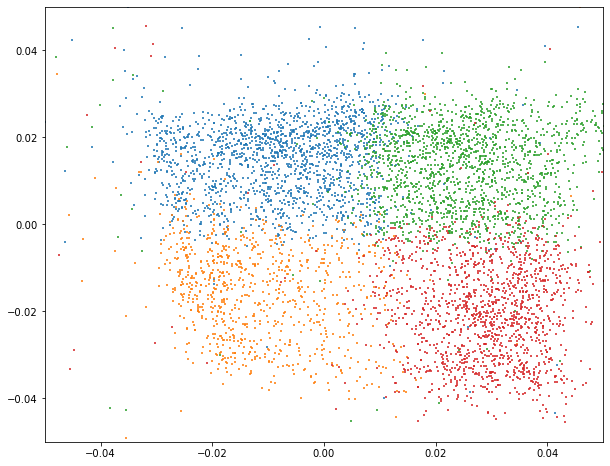

In [48]:
pl.figure(figsize=(10,8))
radiff = (mergetbl['skycoord_466'].ra - mergetbl['skycoord_410'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_466'].dec - mergetbl['skycoord_410'].dec).to(u.arcsec)
topleft = (mergetbl['xcentroid_466'] < 1424) & (mergetbl['ycentroid_466'] > 1024)
pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.8)
topright = (mergetbl['xcentroid_466'] > 1424) & (mergetbl['ycentroid_466'] > 1024)
pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.8)
bottomleft = (mergetbl['xcentroid_466'] < 1424) & (mergetbl['ycentroid_466'] < 1024)
pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.8)
bottomright = (mergetbl['xcentroid_466'] > 1424) & (mergetbl['ycentroid_466'] < 1024)
pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.8)
pl.axis([-0.05,0.05,-0.05,0.05])

In [49]:
mergetbl['xcentroid_466'].max(), mergetbl['ycentroid_466'].max()

(2894.6340156232613, 2290.2184596734805)

In [50]:
dist_from_center = ((mergetbl['xcentroid_466'] - 1450)**2 + (mergetbl['ycentroid_466'] - 1145)**2)**0.5

(0.0, 0.07)

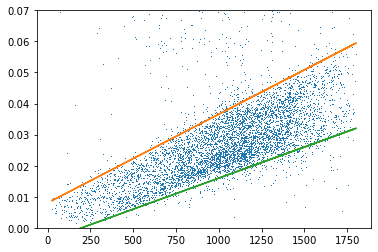

In [55]:
pl.plot(dist_from_center, mergetbl['sep_410_466'].to(u.arcsec).value, ',')
pl.plot(dist_from_center, dist_from_center/1750 * 0.050 + 0.008)
pl.plot(dist_from_center, dist_from_center/1750 * 0.035 - 0.004)
pl.ylim(0,0.07)

In [56]:
ok = (mergetbl['sep_410_466'] < 0.05*u.arcsec) & (mergetbl['sep_410_466'] < (dist_from_center/1750*0.05 +0.08) *u.arcsec) & (mergetbl['sep_410_466'] > (dist_from_center/1750*0.035 - 0.08) *u.arcsec)

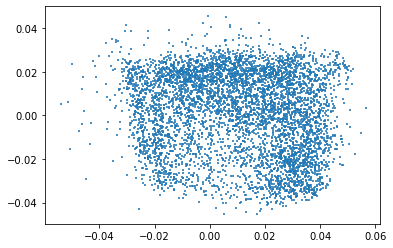

In [57]:
radiff = (mergetbl['skycoord_466'].ra - mergetbl['skycoord_410'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_466'].dec - mergetbl['skycoord_410'].dec).to(u.arcsec)
pl.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.8)

In [58]:
from astropy.wcs.utils import fit_wcs_from_points

In [59]:
ww_466_refit = fit_wcs_from_points([mergetbl['xcentroid_466'][ok], mergetbl['ycentroid_466'][ok]], mergetbl['skycoord_410'][ok], sip_degree=1)

In [61]:
ww_410_refit = fit_wcs_from_points([mergetbl['xcentroid_410'][ok], mergetbl['ycentroid_410'][ok]], mergetbl['skycoord_466'][ok], sip_degree=3)

In [62]:
skycoord_410_refit = ww_410_refit.pixel_to_world(mergetbl['xcentroid_410'], mergetbl['ycentroid_410'])

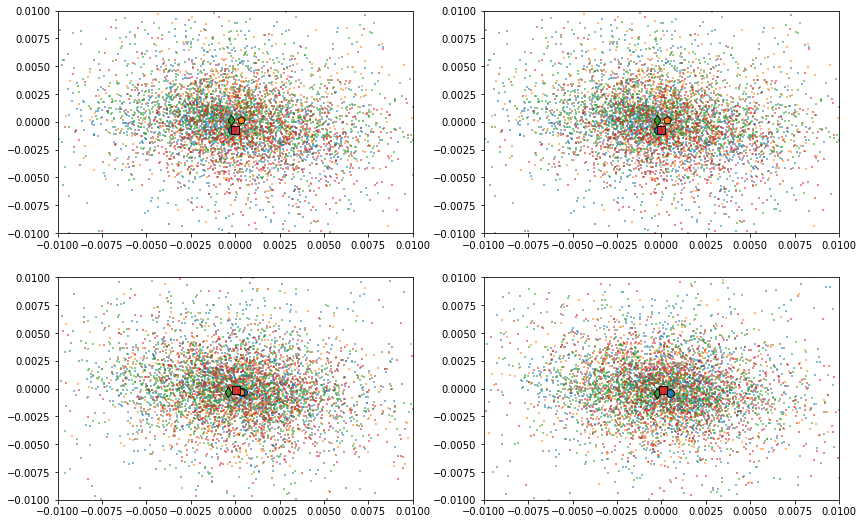

In [63]:
pl.figure(figsize=(14,9))
for sip_degree in (0,1,2,3):
    pl.subplot(2,2,sip_degree+1)
    
    ww_410_refit = fit_wcs_from_points([mergetbl['xcentroid_410'][ok], mergetbl['ycentroid_410'][ok]], mergetbl['skycoord_466'][ok], sip_degree=sip_degree)
    skycoord_410_refit = ww_410_refit.pixel_to_world(mergetbl['xcentroid_410'], mergetbl['ycentroid_410'])
    radiff = (mergetbl['skycoord_466'].ra - skycoord_410_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_466'].dec - skycoord_410_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    ww_410_refit = fit_wcs_from_points([mergetbl['xcentroid_410'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_410'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_466'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
    skycoord_410_refit = ww_410_refit.pixel_to_world(mergetbl['xcentroid_410'], mergetbl['ycentroid_410'])
    radiff = (mergetbl['skycoord_466'].ra - skycoord_410_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_466'].dec - skycoord_410_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    
    topleft = (mergetbl['xcentroid_466'] < 1424) & (mergetbl['ycentroid_466'] > 1024)
    sc = pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topleft]), np.median(decdiff[topleft]), marker='o', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    topright = (mergetbl['xcentroid_466'] > 1424) & (mergetbl['ycentroid_466'] > 1024)
    sc = pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topright]), np.median(decdiff[topright]), marker='p', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomleft = (mergetbl['xcentroid_466'] < 1424) & (mergetbl['ycentroid_466'] < 1024)
    sc = pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomleft]), np.median(decdiff[bottomleft]), marker='d', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomright = (mergetbl['xcentroid_466'] > 1424) & (mergetbl['ycentroid_466'] < 1024)
    sc = pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomright]), np.median(decdiff[bottomright]), marker='s', alpha=0.9, c=sc.get_facecolors(), zorder=25, edgecolors='k', s=60)
    pl.axis([-0.01,0.01,-0.01,0.01])

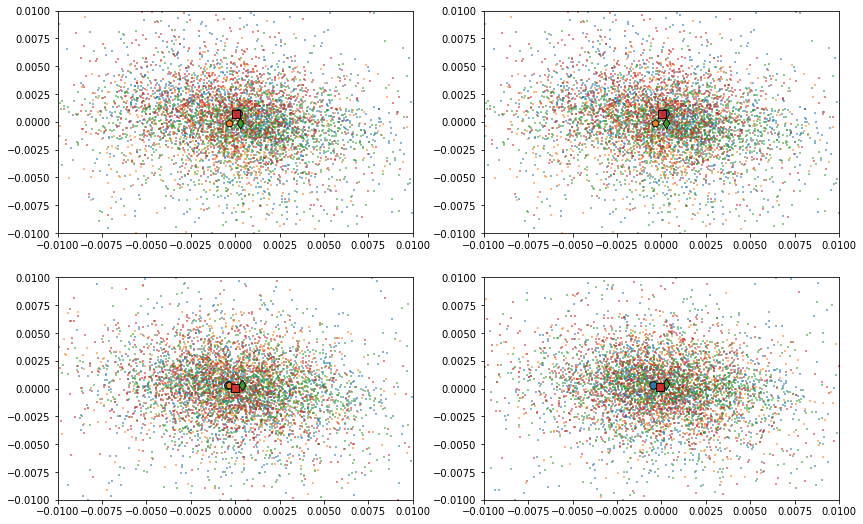

In [64]:
pl.figure(figsize=(14,9))
for sip_degree in (0,1,2,3):
    pl.subplot(2,2,sip_degree+1)
    
    ww_466_refit = fit_wcs_from_points([mergetbl['xcentroid_466'][ok], mergetbl['ycentroid_466'][ok]], mergetbl['skycoord_410'][ok], sip_degree=sip_degree)
    skycoord_466_refit = ww_466_refit.pixel_to_world(mergetbl['xcentroid_466'], mergetbl['ycentroid_466'])
    radiff = (mergetbl['skycoord_410'].ra - skycoord_466_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_410'].dec - skycoord_466_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    ww_466_refit = fit_wcs_from_points([mergetbl['xcentroid_466'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_466'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_410'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
    skycoord_466_refit = ww_466_refit.pixel_to_world(mergetbl['xcentroid_466'], mergetbl['ycentroid_466'])
    radiff = (mergetbl['skycoord_410'].ra - skycoord_466_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_410'].dec - skycoord_466_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    
    topleft = (mergetbl['xcentroid_466'] < 1424) & (mergetbl['ycentroid_466'] > 1024)
    sc = pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topleft]), np.median(decdiff[topleft]), marker='o', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    topright = (mergetbl['xcentroid_466'] > 1424) & (mergetbl['ycentroid_466'] > 1024)
    sc = pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topright]), np.median(decdiff[topright]), marker='p', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomleft = (mergetbl['xcentroid_466'] < 1424) & (mergetbl['ycentroid_466'] < 1024)
    sc = pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomleft]), np.median(decdiff[bottomleft]), marker='d', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomright = (mergetbl['xcentroid_466'] > 1424) & (mergetbl['ycentroid_466'] < 1024)
    sc = pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomright]), np.median(decdiff[bottomright]), marker='s', alpha=0.9, c=sc.get_facecolors(), zorder=25, edgecolors='k', s=60)
    pl.axis([-0.01,0.01,-0.01,0.01])

In [66]:
sip_degree = 3
ww_466_refit = fit_wcs_from_points([mergetbl['xcentroid_466'][ok], mergetbl['ycentroid_466'][ok]], mergetbl['skycoord_410'][ok], sip_degree=sip_degree)
skycoord_466_refit = ww_466_refit.pixel_to_world(mergetbl['xcentroid_466'], mergetbl['ycentroid_466'])
radiff = (mergetbl['skycoord_410'].ra - skycoord_466_refit.ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_410'].dec - skycoord_466_refit.dec).to(u.arcsec)
sep = (radiff**2 + decdiff**2)**0.5
ww_466_refit = fit_wcs_from_points([mergetbl['xcentroid_466'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_466'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_410'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
skycoord_466_refit = ww_466_refit.pixel_to_world(mergetbl['xcentroid_466'], mergetbl['ycentroid_466'])
radiff = (mergetbl['skycoord_410'].ra - skycoord_466_refit.ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_410'].dec - skycoord_466_refit.dec).to(u.arcsec)
sep = (radiff**2 + decdiff**2)**0.5

In [80]:
ww_466_refit.to_header(relax=True).totextfile(f'{basepath}/reduction/headers/f466n_nrca_refitted_to_f410m.hdr')

In [67]:
data_466_proj_410_refit, overlap_refit = reproject.reproject_exact((fh_466['SCI'].data, ww_466_refit), fh_410['SCI'].header)

Set DATE-AVG to '2022-08-28T03:05:31.909' from MJD-AVG.
Set DATE-END to '2022-08-28T03:34:03.557' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.633936 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526083300.815 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [68]:
fits.PrimaryHDU(data=data_466_proj_410_refit, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F466_refitted466wcsto410_nrca.fits', overwrite=True)

In [69]:
f466_minus_cont = data_466_proj_410_refit - cont410_sub_bra #* fractional_bandwidth_466
fits.PrimaryHDU(data=f466_minus_cont, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca.fits', overwrite=True)

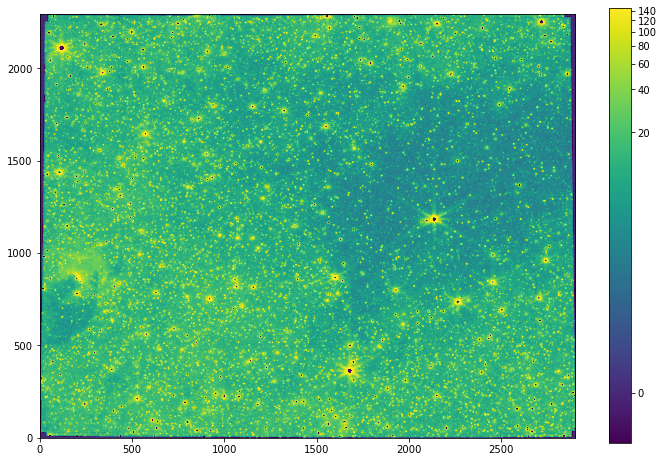

In [70]:
pl.figure(figsize=(12,8))
pl.imshow(cont410_sub_bra, norm=simple_norm(cont410_sub_bra, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

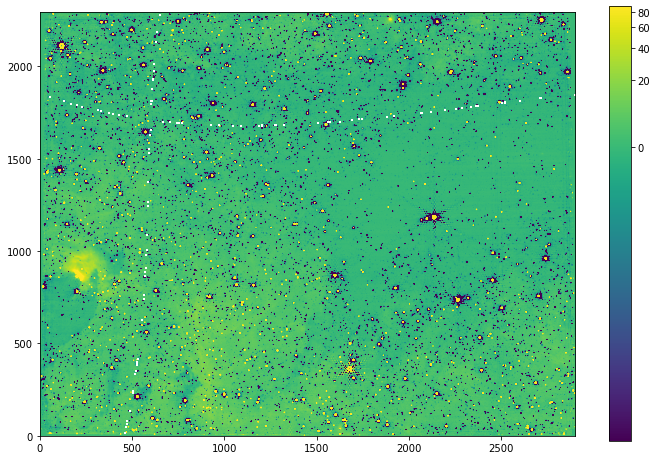

In [71]:
pl.figure(figsize=(12,8))
pl.imshow(f466_minus_cont, norm=simple_norm(f466_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

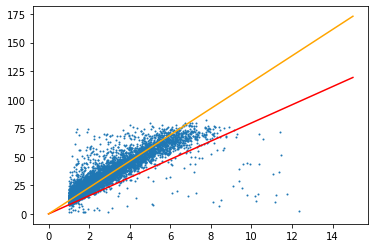

In [76]:
xr = np.linspace(0,15)
pl.scatter(mergetbl['flux_466'][ok], mergetbl['flux_410'][ok], s=1)
pl.plot(xr, xr/fractional_bandwidth_466, color='red')
scalefactor = 0.0867
pl.plot(xr, xr/scalefactor, color='orange')

In [73]:
np.median(1/(mergetbl['flux_410'][ok]/mergetbl['flux_466'][ok]))

0.0866847225040336

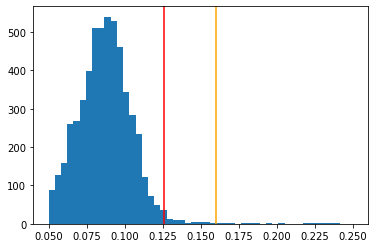

In [74]:
pl.hist(1/(mergetbl['flux_410'][ok]/mergetbl['flux_466'][ok]), bins=np.linspace(0.05,0.25))
pl.axvline(scalefactor, color='orange')
pl.axvline(fractional_bandwidth_466, color='red')

In [78]:
f466_minus_cont = data_466_proj_410_refit - 0.8*cont410_sub_bra #* fractional_bandwidth_466
fits.PrimaryHDU(data=f466_minus_cont, header=fh_410['SCI'].header).writeto(f'{basepath}/images/F466_minus_F410cont_refitted466wcsto410_nrca.fits', overwrite=True)

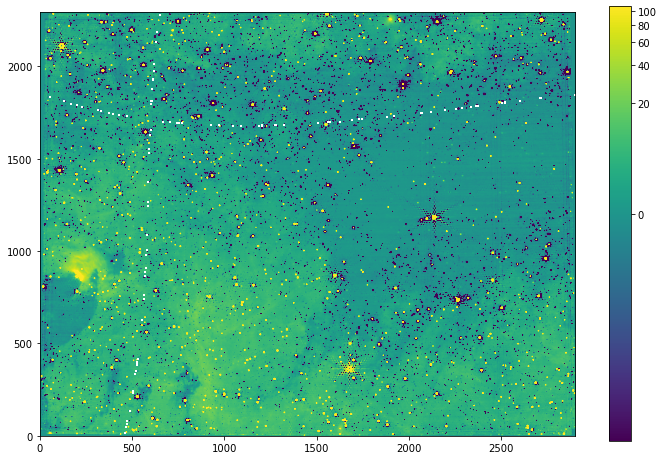

In [79]:
pl.figure(figsize=(12,8))
pl.imshow(f466_minus_cont, norm=simple_norm(f466_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()